# Pipeline for deep learning for image analysis: Predicting age of a child by looking at a hand Xray
The goal of this project is to identify the age of a child from an X-ray of their hand. This data was part of a competition http://rsnachallenges.cloudapp.net/competitions/4. We will build a model inspired by the one used by the winners of the competition.

In [45]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random
from torchvision import models

In [46]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/datasets/kmader/rsna-bone-age/ )<br/>
`kaggle datasets download -d kmader/rsna-bone-age -p PATH` <br/>

In [47]:
PATH = Path("/data2/yinterian/rsna-bone-age/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/rsna-bone-age/rsna-bone-age.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset.csv'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset'),
 PosixPath('/data2/yinterian/rsna-bone-age/mode_tmp.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-550'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-300'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/models'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset.csv'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-300.zip')]

In [48]:
! head /data2/yinterian/rsna-bone-age/boneage-training-dataset.csv

id,boneage,male
1377,180,False
1378,12,False
1379,94,False
1380,120,True
1381,82,False
1382,138,True
1383,150,True
1384,156,True
1385,36,True


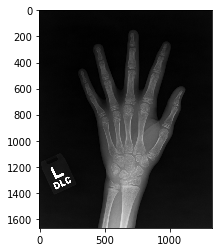

In [49]:
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))  #.astype(np.float32)/255
plt.imshow(im, cmap='gray')

In [6]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(1668, 1323, 3)

In [7]:
# let's look at the typical size of these images
path = PATH/"boneage-training-dataset"
files = list(path.iterdir())[:200]
dims = [cv2.imread(str(p)).shape for p in files]
dims[:10]

[(1818, 1468, 3),
 (1776, 1412, 3),
 (1935, 1657, 3),
 (1478, 955, 3),
 (1622, 1300, 3),
 (1804, 1303, 3),
 (1526, 1132, 3),
 (2570, 2040, 3),
 (1494, 1104, 3),
 (1673, 1304, 3)]

In [8]:
ratios = [x[0]/x[1] for x in dims]

Here is a presentation with EDA on this data
https://alxndrkalinin.github.io/pdf/2017-12_CFT_BoneAge.pdf

## Data augmentation
The winners of the competition used real-time image augmentation consisting of horizontal/vertical translation, zoom, and rotation of 20 percent/degrees as well as horizontal flip. They use 500x500 images.

In [50]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop, resize, horizontal and vertical translations

(534, 534, 3)

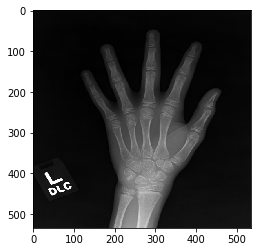

In [10]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))
im = center_crop(im)
im = cv2.resize(im, (550, 550))
im = random_crop(im)
plt.imshow(im, cmap='gray')
im.shape

### Random Rotation (-10, 10) 

-2.2356040634648378


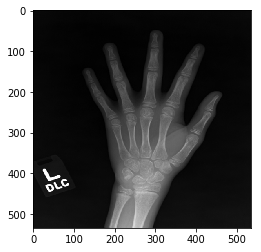

In [11]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

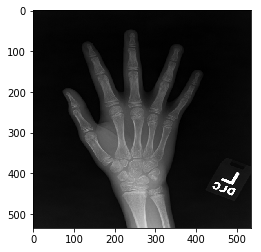

In [12]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Split train and validation

In [13]:
df = pd.read_csv(PATH/"boneage-training-dataset.csv")
train = df.sample(frac=0.8, random_state=3).copy()
valid = df.drop(train.index).copy()

## Saving a resized dataset

In [14]:
# Do this to save time at training.
PATH_300 = PATH/"boneage-300"
#PATH_300.mkdir()

In [15]:
def get_a_crop(path, sz=300):
    im = cv2.imread(str(path))
    r,c,_ = im.shape
    pad = abs(r-c)//4
    if r > c :
        im2 = cv2.copyMakeBorder(im, 0, 0, pad, pad, cv2.BORDER_REFLECT)
    else:
        im2 = cv2.copyMakeBorder(im, pad, pad, 0, 0, cv2.BORDER_REFLECT)
    return cv2.resize(center_crop(im2), (sz, sz))

In [16]:
from os import listdir
from os.path import join
def resize_all_images():
    for f in listdir(PATH/"boneage-training-dataset/"):
        old_path = join(PATH/"boneage-training-dataset/", f)
        new_path = join(PATH/"boneage-300/", f)
        img2 = get_a_crop(old_path)
        cv2.imwrite(new_path, img2)

In [17]:
#resize_all_images()

## Dataset

In [51]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

class BoneAgeDataset(Dataset):
    def __init__(self, df, transform=True, sz=300):
        self.path_to_images = PATH/"boneage-300/"
        self.transform = transform
        self.df = df
        self.sz = sz
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = str(self.path_to_images) + "/" + str(row["id"]) + ".png"
        y = row["boneage"]
        x = cv2.imread(str(path)).astype(np.float32)/255
        if self.transform:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            x = random_crop(x)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
        else:
            x = center_crop(x)
        x = normalize(x)
        return np.rollaxis(x, 2), y[None]

In [19]:
train_ds = BoneAgeDataset(train)
valid_ds = BoneAgeDataset(valid, transform=False)

In [20]:
x, y = train_ds[0]
x.shape, y.shape

((3, 284, 284), (1,))

In [21]:
x, y = valid_ds[0]
x.shape, y.shape

((3, 284, 284), (1,))

## Model

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Linear(512, 1)

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [60]:
class Net50(nn.Module):
    def __init__(self):
        super(Net50, self).__init__()
        resnet = models.resnet50(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Linear(2048, 1)

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Finding optimal learning rate range
From this paper https://arxiv.org/pdf/1506.01186.pdf.
This an implementation of the "LR range test". Run your model for several epochs while letting the learning rate increase linearly between low and high LR values. Next, plot the loss versus learning rate. Note the learning rate value when the loss starts to decrease and when the loss slows, becomes ragged, or increases. In the example below the range seem to be from `1e-5` to `0.012`.

In [55]:
def create_optimizer(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/9},
              {'params': model.features2.parameters(), 'lr': lr0/3},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=1e-5)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [56]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.01, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    optimizer = create_optimizer(model, lrs[0])
    ind = 0
    for i in range(epochs):
        for x, y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.l1_loss(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [57]:
train_ds = BoneAgeDataset(train)
valid_ds = BoneAgeDataset(valid, transform=False)
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=1)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=1)

In [61]:
model = Net50().cuda()
lrs, losses = LR_range_finder(model, train_dl)

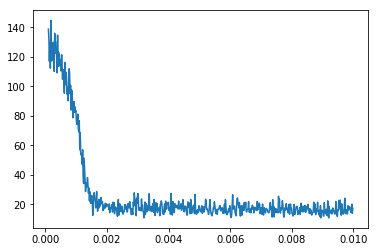

In [62]:
# first plot the whole graph
plt.plot(lrs, losses)
plt.show()

## Trainning with one cycle learning

Before training with this policy you have to estimate the range of learning rates using previous function.

In [63]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

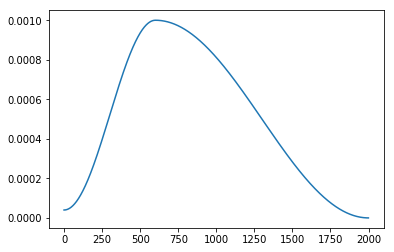

In [64]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [65]:
def train_one_epoch(model, optimizer, train_dl, lrs, idx):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        lr = lrs[idx]
        update_optimizer(optimizer, [lr/9, lr/3, lr])
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().float()
        out = model(x)
        loss = F.l1_loss(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        idx += 1
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total, idx

In [66]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_loss = 10000.0
    for i in range(epochs):
        train_loss, idx = train_one_epoch(model, optimizer, train_dl, lrs, idx)
        val_loss = val_metric(model, valid_dl)
        print("train_loss %.3f val_loss %.3f" % (train_loss, val_loss))
        if val_loss < prev_val_loss: 
            prev_val_loss = val_loss
            path = "{0}/models/model_resnet34_{1:.0f}.pth".format(PATH, 100*val_loss)
            if val_loss < 9:
                save_model(model, path)
                print(path)

In [67]:
def val_metric(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    with torch.no_grad():
        for x, y in valid_dl:
            batch = x.shape[0]
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.l1_loss(out, y)
            sum_loss += batch*(loss.item())
            total += batch
    return sum_loss/total

In [68]:
model = Net50().cuda()
val_metric(model, valid_dl)

127.43406734118662

In [ ]:
from datetime import datetime
start = datetime.now() 
model = Net50().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.0005, epochs = 25)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of step", t)

In [72]:
from datetime import datetime
start = datetime.now() 
model = Net50().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.001, epochs = 25)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of step", t)

train_loss 114.547 val_loss 99.447
train_loss 68.647 val_loss 26.105
train_loss 15.206 val_loss 16.949
train_loss 13.056 val_loss 11.728
train_loss 12.937 val_loss 18.958
train_loss 12.316 val_loss 12.417
train_loss 12.275 val_loss 11.064
train_loss 11.434 val_loss 10.699
train_loss 11.222 val_loss 10.597
train_loss 11.017 val_loss 13.827
train_loss 10.869 val_loss 10.416
train_loss 10.540 val_loss 10.973
train_loss 10.332 val_loss 9.965
train_loss 9.749 val_loss 11.172
train_loss 9.467 val_loss 9.889
train_loss 9.245 val_loss 9.634
train_loss 8.825 val_loss 9.695
train_loss 8.662 val_loss 10.881
train_loss 8.389 val_loss 10.008
train_loss 8.140 val_loss 9.212
train_loss 7.873 val_loss 8.930
/data2/yinterian/rsna-bone-age/models/model_resnet34_893.pth
train_loss 7.705 val_loss 8.841
/data2/yinterian/rsna-bone-age/models/model_resnet34_884.pth
train_loss 7.547 val_loss 8.888
train_loss 7.465 val_loss 8.851
train_loss 7.338 val_loss 8.853
----End of step Time elapsed 0:47:00.055139


In [71]:
from datetime import datetime
start = datetime.now() 
model = Net50().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.002, epochs = 25)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of step", t)

train_loss 103.702 val_loss 71.039
train_loss 29.401 val_loss 14.213
train_loss 13.941 val_loss 13.855
train_loss 13.155 val_loss 13.935
train_loss 12.927 val_loss 12.524
train_loss 12.734 val_loss 13.578
train_loss 12.734 val_loss 12.662
train_loss 12.507 val_loss 11.539
train_loss 11.665 val_loss 13.256
train_loss 11.428 val_loss 11.154
train_loss 11.354 val_loss 11.649
train_loss 11.201 val_loss 9.966
train_loss 10.752 val_loss 11.179
train_loss 10.243 val_loss 9.921
train_loss 10.137 val_loss 11.073
train_loss 9.976 val_loss 9.612
train_loss 9.513 val_loss 9.914
train_loss 9.072 val_loss 9.207
train_loss 8.769 val_loss 9.359
train_loss 8.473 val_loss 9.149
train_loss 8.125 val_loss 9.080
train_loss 7.921 val_loss 9.044
train_loss 7.738 val_loss 8.995
/data2/yinterian/rsna-bone-age/models/model_resnet34_899.pth
train_loss 7.648 val_loss 8.937
/data2/yinterian/rsna-bone-age/models/model_resnet34_894.pth
train_loss 7.628 val_loss 8.967
----End of step Time elapsed 0:46:54.727544


In [70]:
from datetime import datetime
start = datetime.now() 
model = Net50().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.005, epochs = 25)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of step", t)

train_loss 66.959 val_loss 15.527
train_loss 14.574 val_loss 26.704
train_loss 13.826 val_loss 12.880
train_loss 13.925 val_loss 15.698
train_loss 13.443 val_loss 13.340
train_loss 13.473 val_loss 16.988
train_loss 13.091 val_loss 12.590
train_loss 12.814 val_loss 19.009
train_loss 12.839 val_loss 11.285
train_loss 12.551 val_loss 13.927
train_loss 12.276 val_loss 12.389
train_loss 11.572 val_loss 11.144
train_loss 11.451 val_loss 10.311
train_loss 11.067 val_loss 14.763
train_loss 10.892 val_loss 10.153
train_loss 10.248 val_loss 10.536
train_loss 10.154 val_loss 12.192
train_loss 9.770 val_loss 10.400
train_loss 9.366 val_loss 9.909
train_loss 9.083 val_loss 9.921
train_loss 8.721 val_loss 9.103
train_loss 8.313 val_loss 9.285
train_loss 8.117 val_loss 9.129
train_loss 7.969 val_loss 9.105
train_loss 7.918 val_loss 9.043
----End of step Time elapsed 0:46:50.784058


In [42]:
from datetime import datetime
start = datetime.now() 
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs = 25)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of step", t)

train_loss 35.053 val_loss 18.169
train_loss 15.570 val_loss 12.998
train_loss 15.036 val_loss 18.523
train_loss 14.992 val_loss 14.022
train_loss 14.533 val_loss 13.087
train_loss 14.387 val_loss 14.513
train_loss 14.010 val_loss 14.074
train_loss 13.475 val_loss 13.563
train_loss 13.113 val_loss 12.057
train_loss 12.753 val_loss 11.533
train_loss 12.134 val_loss 14.246
train_loss 12.225 val_loss 11.632
train_loss 11.689 val_loss 11.331
train_loss 11.159 val_loss 11.767
train_loss 10.868 val_loss 11.594
train_loss 10.390 val_loss 10.545
train_loss 10.062 val_loss 9.659
train_loss 9.674 val_loss 9.695
train_loss 9.366 val_loss 10.269
train_loss 8.952 val_loss 10.655
train_loss 8.836 val_loss 9.295
train_loss 8.539 val_loss 9.398
train_loss 8.302 val_loss 9.139
train_loss 8.210 val_loss 9.121
train_loss 8.206 val_loss 9.216
----End of step Time elapsed 0:36:47.720917


In [37]:
from datetime import datetime
start = datetime.now() 
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.005, epochs = 25)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of step", t)

train_loss 51.092 val_loss 15.249
train_loss 15.748 val_loss 14.301
train_loss 14.730 val_loss 14.166
train_loss 14.052 val_loss 14.016
train_loss 13.740 val_loss 12.007
train_loss 13.589 val_loss 13.232
train_loss 13.054 val_loss 13.869
train_loss 12.546 val_loss 10.680
train_loss 12.218 val_loss 12.009
train_loss 12.097 val_loss 11.700
train_loss 11.533 val_loss 10.483
train_loss 11.315 val_loss 11.411
train_loss 10.826 val_loss 10.810
train_loss 10.641 val_loss 10.705
train_loss 10.174 val_loss 9.933
train_loss 9.891 val_loss 9.816
train_loss 9.659 val_loss 9.771
train_loss 9.373 val_loss 10.838
train_loss 8.862 val_loss 9.721
train_loss 8.690 val_loss 9.489
train_loss 8.401 val_loss 9.324
train_loss 8.156 val_loss 9.275
train_loss 8.013 val_loss 9.128
train_loss 7.884 val_loss 9.158
train_loss 7.823 val_loss 9.129
----End of step Time elapsed 0:37:14.832587


# References

* https://www.16bit.ai/blog/ml-and-future-of-radiology
* https://stanfordmedicine.app.box.com/s/vhq1zop1867gr9rwnan4byj8lfxue173
* https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb